Import all dependencies

In [1]:
from typing import Dict, Tuple
from matplotlib import pyplot as plt
from numba import cuda
import numpy as np
import cv2
import math

Helper functions for displaying images

In [2]:
def show_image(img: np.ndarray, window_name: str) -> None:
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(window_name)
    plt.show()

def show_subplot(named_imgs: Dict[str, np.ndarray], img_shape: np.ndarray.shape) -> None:
    f, axarr = plt.subplots(1, len(named_imgs))
    f.set_figheight(len(named_imgs)*4)
    f.set_figwidth(len(named_imgs)*4)

    for idx, (name, img) in enumerate(named_imgs.items()):
        out_img = None

        # Copy the image from device or host memory
        if (cuda.is_cuda_array(img)):
            out_img = img.copy_to_host()
            out_img = out_img.reshape(img_shape)
        else:
            out_img = img.copy()

        # Ensure image is within bounds
        if (out_img.min() < 0 or out_img.max() > 1):
            out_img = np.clip(out_img, 0, 1)

        # BW to color
        if (out_img.ndim == 2):
            out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2RGB)

        axarr[idx].set_title(name)
        axarr[idx].imshow(out_img)

Default kernels

In [3]:
kernel_sobel_left = cuda.to_device(np.array([[ 1,  0, -1], 
                                             [ 2,  0, -2], 
                                             [ 1,  0, -1]], np.float32))

kernel_sobel_top  = cuda.to_device(np.array([[ 1,  2,  1], 
                                             [ 0,  0,  0], 
                                             [-1, -2, -1]], np.float32))

kernel_sharpen    = cuda.to_device(np.array([[ 0, -1,  0], 
                                             [-1,  5, -1], 
                                             [ 0, -1,  0]], np.float32))

kernel_blur_3     = cuda.to_device(np.array([[ 1,  2,  1], 
                                             [ 2,  4,  2], 
                                             [ 1,  2,  1]], np.float32) / 16)

kernel_blur_5     = cuda.to_device(np.array([[1,  4,  6,  4,  1], 
                                             [4, 16, 24, 16,  4], 
                                             [6, 24, 36, 24,  6],
                                             [4, 16, 24, 16,  4],
                                             [1,  4,  6,  4,  1]], np.float32) / 256)

Load the base image

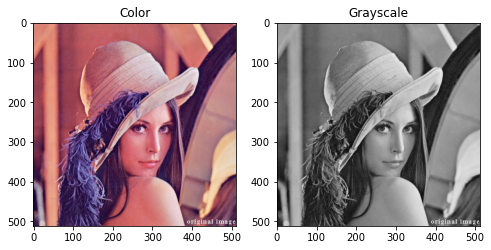

In [4]:
raw_img = cv2.imread('imgs/lena_color.jpg')
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
raw_bw_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2GRAY)

# Normalize to 0..1
col_img = raw_img.astype(np.float32)
col_img /= 255.
bw_img = raw_bw_img.astype(np.float32)
bw_img /= 255.

img_shape = bw_img.shape

# Create cuda image to work with
cuda_img_input = cuda.to_device(bw_img.ravel())

show_subplot({"Color": col_img, "Grayscale": bw_img}, img_shape)

Generate cuda kernel dimensions

In [5]:
imgH = img_shape[0]
imgW = img_shape[1]
cuda_img_shape = cuda.to_device(img_shape)

blockSize = imgW
blockPerLine = 1

if (imgW > 1024):
    blockSize = 256
    blockPerLine = math.ceil(imgW / blockSize)

# Each px will have its own cuda thread
gridDim = (blockPerLine, imgH)
blockDim = (blockSize, 1)

Init all the images buffers we will need

In [6]:
cuda_img_sharpen      = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_blur3        = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_blur5        = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_sobel_top    = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_sobel_left   = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_sobel        = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_angles       = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_thinned      = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_thresh_upper = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_thresh_lower = cuda.device_array(cuda_img_input.shape, np.float32)
cuda_img_ccl          = cuda.device_array(cuda_img_input.shape, np.uint32)
cuda_img_ccl_hys      = cuda.device_array(cuda_img_input.shape, np.uint32)
cuda_img_hysteresis   = cuda.device_array(cuda_img_input.shape, np.float32)

Create function for generating convolutions

In [7]:
# Func returns the x/y index relative to the kernel center being location (0,0)
@cuda.jit(device=True)
def get_kernel_center_offset(k_size: int, x: int, y: int) -> Tuple[int, int]:
    target = int(k_size/2) + 1
    out_x = (x-target) +1
    out_y = (y-target) +1

    return out_x, out_y

# We launch one cuda thread per px. Each launch will represent a px output location
@cuda.jit
def convolve(cuda_img_in: cuda.np.ndarray, cuda_img_shape: cuda.np.ndarray, cuda_img_kernel: cuda.np.ndarray, cuda_img_out: cuda.np.ndarray, normalize: bool) -> None:
    imgH = cuda_img_shape[0]
    imgW = cuda_img_shape[1]

    img_row = cuda.blockIdx.y
    img_col = (cuda.blockIdx.x * cuda.blockDim.x) + cuda.threadIdx.x
    img_out_idx = img_row * imgW + img_col

    px_out = 0

    kern_pos = 0
    kern_neg = 0

    # We could use len(kernel.ravel) as the grid.z rather than looping, but writing px will have to become an atomic add...
    for ker_y in range(cuda_img_kernel.shape[0]):
        for ker_x in range(cuda_img_kernel.shape[1]):
            if cuda_img_kernel[ker_y, ker_x] > 0:
                kern_pos += cuda_img_kernel[ker_y, ker_x]
            if cuda_img_kernel[ker_y, ker_x] < 0:
                kern_neg += cuda_img_kernel[ker_y, ker_x]

            ker_offset_x, ker_offset_y = get_kernel_center_offset(cuda_img_kernel.shape[0], ker_x, ker_y)

            # If out-of-bounds, use a valid neighbor px
            if (img_col+ker_offset_x < 0) or (img_col+ker_offset_x > imgW):
                ker_offset_x = 0
            if (img_row+ker_offset_y < 0) or (img_row+ker_offset_y > imgH):
                ker_offset_y = 0

            img_in_idx = ((img_row + ker_offset_y) * imgW) + (img_col + ker_offset_x)
            px_out += (cuda_img_in[img_in_idx] * cuda_img_kernel[ker_y, ker_x])

    if (normalize):
        px_out = (px_out - kern_neg) / (kern_pos - kern_neg)

    cuda_img_out[img_out_idx] = px_out

Generate and display various convolutions 

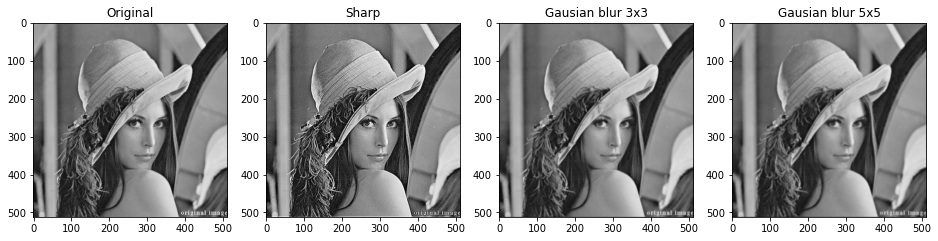

In [8]:
convolve[gridDim, blockDim](cuda_img_input, cuda_img_shape, kernel_sharpen, cuda_img_sharpen, False)
convolve[gridDim, blockDim](cuda_img_input, cuda_img_shape, kernel_blur_3, cuda_img_blur3, True)
convolve[gridDim, blockDim](cuda_img_input, cuda_img_shape, kernel_blur_5, cuda_img_blur5, True)

show_subplot({'Original': bw_img,
              'Sharp': cuda_img_sharpen,
              'Gausian blur 3x3': cuda_img_blur3,
              'Gausian blur 5x5': cuda_img_blur5}, img_shape)

Cuda kernels for hypot and arctan

In [9]:
@cuda.jit
def hypot_img(cuda_img_a: cuda.np.ndarray, cuda_img_b: cuda.np.ndarray, cuda_img_shape: cuda.np.ndarray, cuda_img_out: cuda.np.ndarray) -> None:
    img_row = cuda.blockIdx.y
    img_col = (cuda.blockIdx.x * cuda.blockDim.x) + cuda.threadIdx.x
    img_idx = img_row * cuda_img_shape[1] + img_col

    cuda_img_out[img_idx] = math.sqrt((cuda_img_a[img_idx]**2) + (cuda_img_b[img_idx]**2))

# Returns the element-wise angle in degrees from atan2 of img_a,img_b
@cuda.jit
def atan2_img_degrees(cuda_img_a: cuda.np.ndarray, cuda_img_b: cuda.np.ndarray, cuda_img_shape: cuda.np.ndarray, cuda_img_out: cuda.np.ndarray) -> None:
    img_row = cuda.blockIdx.y
    img_col = (cuda.blockIdx.x * cuda.blockDim.x) + cuda.threadIdx.x
    img_idx = img_row * cuda_img_shape[1] + img_col

    cuda_img_out[img_idx] = cuda.libdevice.atan2f(cuda_img_a[img_idx], cuda_img_b[img_idx]) * 180. / math.pi

Generate the sobel from top and left filters

In [10]:
# Detect edges
convolve[gridDim, blockDim](cuda_img_blur3, cuda_img_shape, kernel_sobel_top, cuda_img_sobel_top, False)
convolve[gridDim, blockDim](cuda_img_blur3, cuda_img_shape, kernel_sobel_left, cuda_img_sobel_left, False)
hypot_img[gridDim, blockDim](cuda_img_sobel_top, cuda_img_sobel_left, cuda_img_shape, cuda_img_sobel)
atan2_img_degrees[gridDim, blockDim](cuda_img_sobel_top, cuda_img_sobel_left, cuda_img_shape, cuda_img_angles)

Use non-max suppression as the thinning algorithm

In [11]:
# Thins lines based on the intensity of the prev/next px
@cuda.jit
def non_max_suppression(cuda_img_in: cuda.np.ndarray, cuda_img_angles: cuda.np.ndarray, cuda_img_shape: cuda.np.ndarray, cuda_img_out: cuda.np.ndarray) -> None:
    imgW = cuda_img_shape[1]

    img_row = cuda.blockIdx.y
    img_col = (cuda.blockIdx.x * cuda.blockDim.x) + cuda.threadIdx.x
    img_idx = img_row * imgW + img_col

    curr_angle = cuda_img_angles[img_idx]
    if (curr_angle < 0): curr_angle += 180
    px_curr = cuda_img_in[img_idx]
    px_prev = px_curr
    px_next = px_curr

    if (0 <= curr_angle < 22.5) or (157.5 <= curr_angle <= 180): # Angle 0
        px_prev = cuda_img_in[((img_row) * imgW) + (img_col - 1)]
        px_next = cuda_img_in[((img_row) * imgW) + (img_col + 1)]
    elif (22.5 <= curr_angle < 67.5): # Angle 45
        px_prev = cuda_img_in[((img_row - 1) * imgW) + (img_col + 1)]
        px_next = cuda_img_in[((img_row + 1) * imgW) + (img_col - 1)]
    elif (67.5 <= curr_angle < 112.5): # Angle 90
        px_prev = cuda_img_in[((img_row - 1) * imgW) + (img_col)]
        px_next = cuda_img_in[((img_row + 1) * imgW) + (img_col)]
    elif (112.5 <= curr_angle < 157.5): # Angle 135
        px_prev = cuda_img_in[((img_row - 1) * imgW) + (img_col - 1)]
        px_next = cuda_img_in[((img_row + 1) * imgW) + (img_col + 1)]

    if (px_prev <= px_curr >= px_next):
        cuda_img_out[img_idx] = px_curr
    else:
        cuda_img_out[img_idx] = 0


Thin the image and show the image steps 

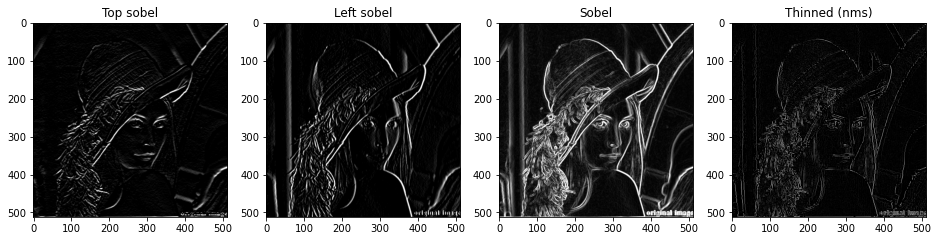

In [12]:
non_max_suppression[gridDim, blockDim](cuda_img_sobel, cuda_img_angles, cuda_img_shape, cuda_img_thinned)

show_subplot({'Top sobel': cuda_img_sobel_top,
              'Left sobel': cuda_img_sobel_left,
              'Sobel': cuda_img_sobel,
              'Thinned (nms)': cuda_img_thinned}, img_shape)

Function for thresholding

In [13]:
@cuda.jit
def threshold(cuda_img_in: cuda.np.ndarray, cuda_img_shape: cuda.np.ndarray, thresh: float, cuda_img_out: cuda.np.ndarray) -> None:
    imgW = cuda_img_shape[1]
    img_row = cuda.blockIdx.y
    img_col = (cuda.blockIdx.x * cuda.blockDim.x) + cuda.threadIdx.x
    img_idx = img_row * imgW + img_col
    curr_px = cuda_img_in[img_idx]

    cuda_img_out[img_idx] = float(int(curr_px >= thresh))

Functions for generating connected component labels

In [14]:
@cuda.jit
def ccl_init(cuda_img_binary: cuda.np.ndarray, cuda_img_shape: cuda.np.ndarray, cuda_label_img: cuda.np.ndarray) -> None:
    imgW = cuda_img_shape[1]
    img_row = cuda.blockIdx.y
    img_col = (cuda.blockIdx.x * cuda.blockDim.x) + cuda.threadIdx.x
    img_idx = img_row * imgW + img_col
    cuda_label_img[img_idx] = img_idx * cuda_img_binary[img_idx]

@cuda.jit
def ccl_scan(cuda_label_img: cuda.np.ndarray, cuda_img_shape: cuda.np.ndarray, change_flag: cuda.np.ndarray) -> None:
    imgH = cuda_img_shape[0]
    imgW = cuda_img_shape[1]
    img_row = cuda.blockIdx.y
    img_col = (cuda.blockIdx.x * cuda.blockDim.x) + cuda.threadIdx.x
    img_idx = img_row * imgW + img_col
    min_label = cuda_label_img[img_idx]

    if (min_label == 0):
        return

    for r in range(-1,2):
        if (imgH < img_row + r < 0):
            continue
        for c in range(-1,2):
            if (imgW < img_col + c < 0):
                continue

            neighbor_label = cuda_label_img[(img_row+r) * imgW + (img_col+c)]
            if (neighbor_label != 0.0 and neighbor_label < min_label):
                min_label = neighbor_label
                change_flag[0] = True

    cuda_label_img[img_idx] = min_label

@cuda.jit
def ccl_analyze(cuda_label_img: cuda.np.ndarray, cuda_img_shape: cuda.np.ndarray) -> None:
    imgW = cuda_img_shape[1]
    img_row = cuda.blockIdx.y
    img_col = (cuda.blockIdx.x * cuda.blockDim.x) + cuda.threadIdx.x
    img_idx = img_row * imgW + img_col

    curr_label = cuda_label_img[img_idx]
    new_label = cuda_label_img[curr_label]

    if (curr_label != 0):
        while (curr_label != new_label):
            curr_label = new_label
            new_label = min(new_label, cuda_label_img[curr_label])
        cuda_label_img[img_idx] = curr_label

def ccl(cuda_img_in: cuda.np.ndarray, cuda_label_img: cuda.np.ndarray) -> None:
    ccl_init[gridDim, blockDim](cuda_img_in, cuda_img_shape, cuda_label_img)

    h_any_changes = True

    while (h_any_changes):
        d_any_changes = cuda.to_device([False])
        ccl_scan[gridDim, blockDim](cuda_label_img, cuda_img_shape, d_any_changes)
        ccl_analyze[gridDim, blockDim](cuda_label_img, cuda_img_shape)
        h_any_changes = d_any_changes.copy_to_host()[0]


Function for hysteresis to combine various thresholds

In [15]:
@cuda.jit
def hysteresis_ccl_init(cuda_img_upper: cuda.np.ndarray, cuda_img_shape: cuda.np.ndarray, cuda_ccl_lower: cuda.np.ndarray, cuda_ccl_hys: cuda.np.ndarray) -> None:
    # Using ccl's of lower thresh, if a label is touching an upper thresh, copy that label to a hysteresis label image
    imgH = cuda_img_shape[0]
    imgW = cuda_img_shape[1]
    img_row = cuda.blockIdx.y
    img_col = (cuda.blockIdx.x * cuda.blockDim.x) + cuda.threadIdx.x
    img_idx = img_row * imgW + img_col
    label = cuda_ccl_lower[img_idx]

    # Using ccl's from lower thresh
    if label > 0:
        for r in range(-1,2):
            for c in range(-1,2):
                if (imgW < img_col + c < 0) or (imgH < img_row + r < 0):
                    continue # Out-of-bounds
                n_idx = (img_row+r) * imgW + (img_col+c)
                if cuda_img_upper[n_idx]:
                    cuda_ccl_hys[img_idx] = label
                    cuda_ccl_hys[label] = label

@cuda.jit
def hysteresis_ccl(cuda_img_upper: cuda.np.ndarray, cuda_img_shape: cuda.np.ndarray, cuda_ccl_lower: cuda.np.ndarray, cuda_ccl_hys: cuda.np.ndarray, cuda_img_out: cuda.np.ndarray) -> None:
    imgW = cuda_img_shape[1]
    img_row = cuda.blockIdx.y
    img_col = (cuda.blockIdx.x * cuda.blockDim.x) + cuda.threadIdx.x
    img_idx = img_row * imgW + img_col

    #cuda_img_out[img_idx] = cuda_img_upper[img_idx]
    if cuda_img_upper[img_idx] > 0.5:
        cuda_img_out[img_idx] = 1.0
    # elif a lower thresh from a connected component touching an upper thresh
    if cuda_ccl_hys[cuda_ccl_lower[img_idx]] > 0:
        cuda_img_out[img_idx] = 1.0

def hysteresis(cuda_img_upper: cuda.np.ndarray, cuda_ccl_lower: cuda.np.ndarray, cuda_ccl_hys: cuda.np.ndarray, cuda_img_out: cuda.np.ndarray) -> None:
    hysteresis_ccl_init[gridDim, blockDim](cuda_img_upper, cuda_img_shape, cuda_ccl_lower, cuda_ccl_hys)
    hysteresis_ccl[gridDim, blockDim](cuda_img_upper, cuda_img_shape, cuda_ccl_lower, cuda_ccl_hys, cuda_img_out)

Generate canny edges using hysteresis

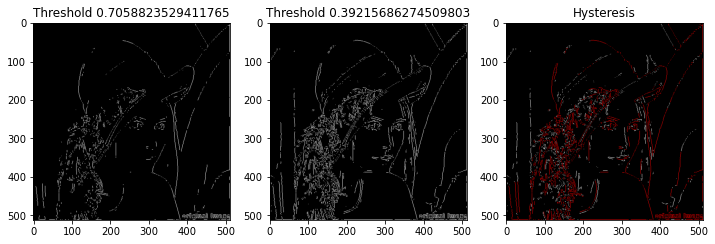

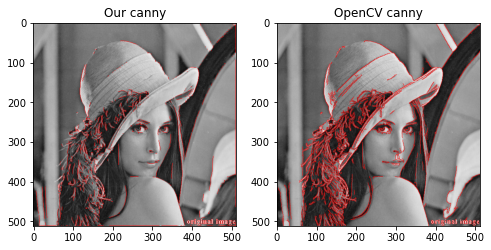

In [16]:
upper_thresh = float(150/255)
lower_thresh = float(80/255)
threshold[gridDim, blockDim](cuda_img_thinned, cuda_img_shape, upper_thresh, cuda_img_thresh_upper)
threshold[gridDim, blockDim](cuda_img_thinned, cuda_img_shape, lower_thresh, cuda_img_thresh_lower)
ccl(cuda_img_thresh_lower, cuda_img_ccl)
hysteresis(cuda_img_thresh_upper, cuda_img_ccl, cuda_img_ccl_hys, cuda_img_hysteresis)

# For display
img_threshed = cuda_img_thresh_lower.copy_to_host().reshape(img_shape)
img_hysteresis = cuda_img_hysteresis.copy_to_host().reshape(img_shape)

img_hys_over_thresh = np.dstack((img_threshed, img_threshed, img_threshed))
img_hys_over_thresh[img_hysteresis == img_hysteresis.max()] = (1.0, 0.0, 0.0)

img_hys_over_orig = np.dstack((bw_img, bw_img, bw_img))
img_hys_over_orig[img_hysteresis == img_hysteresis.max()] = (1.0, 0.0, 0.0)

# Use cv2.canny as a comparison
img_cv2_canny = cv2.Canny(raw_bw_img, 100, 240, apertureSize=3)
img_overlay2 = np.dstack((bw_img, bw_img, bw_img))
img_overlay2[img_cv2_canny == img_cv2_canny.max()] = (1.0, 0.0, 0.0)

show_subplot({f'Threshold {upper_thresh}': cuda_img_thresh_upper, f'Threshold {lower_thresh}': cuda_img_thresh_lower, 'Hysteresis': img_hys_over_thresh}, img_shape)
show_subplot({'Our canny': img_hys_over_orig, 'OpenCV canny': img_overlay2}, img_shape)